To use:
- Mount Drive
- Upload models.py
- Select file by commenting

In [ ]:
# Run this cell if using Google Colab
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/JP_gmvae_data/

Mounted at /content/drive


./VAE_figs/UOP_uniform_pGRAM_cn_dim8_64x32x16_beta0.0013_batch128_epochs3000_0515095556
Loaded 1547 samples with label 0.
total loss function calls:  36257.8125
VAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): GELU(approximate='none')
    )
    (1): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): GELU(approximate='none')
    )
    (2): Sequential(
      (0): Linear(in_features=32, out_features=16, bias=True)
      (1): GELU(approximate='none')
    )
  )
  (fc_mu): Linear(in_features=16, out_features=8, bias=True)
  (fc_var): Linear(in_features=16, out_features=8, bias=True)
  (decoder_input): Linear(in_features=8, out_features=16, bias=True)
  (decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=16, out_features=32, bias=True)
      (1): GELU(approximate='none')
    )
    (1): Sequential(
      (0): Linear(in_features=32, out_features=64, bias=True)
     

100%|██████████| 3000/3000 [01:01<00:00, 48.68 Epoch/s, loss=0.0181]


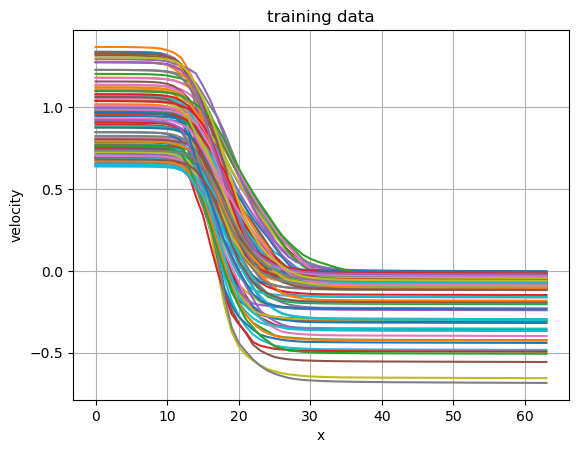

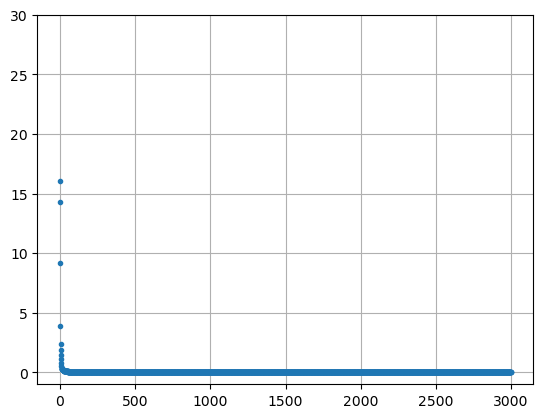

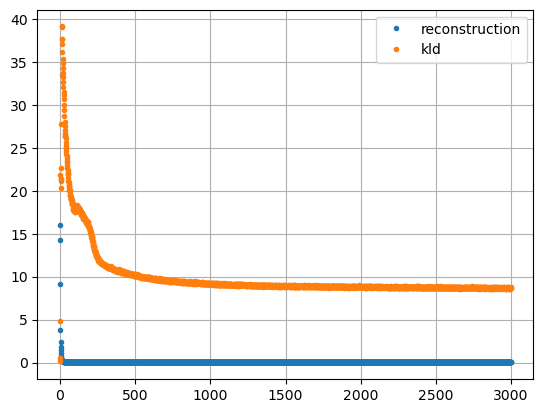

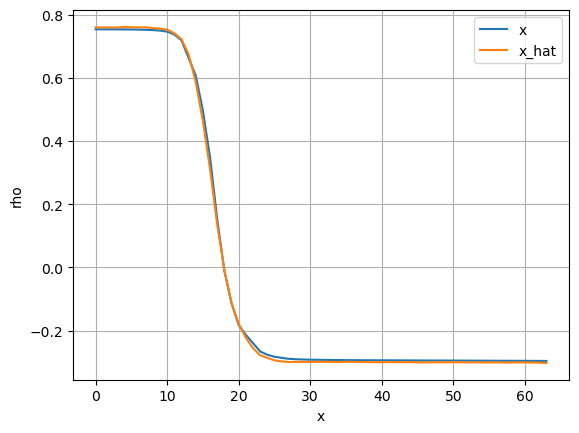

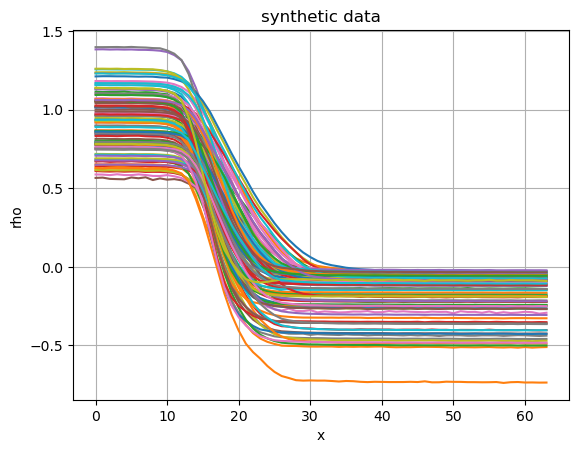

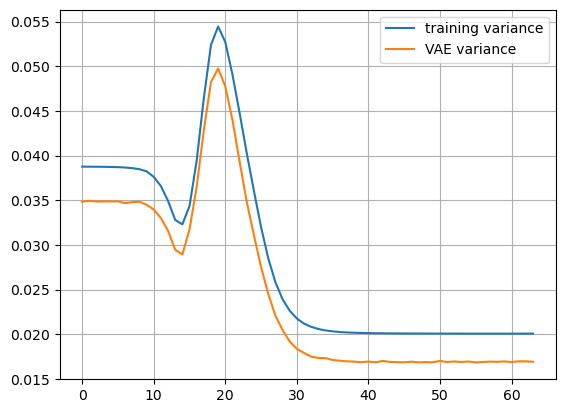

In [22]:
import torch 
from models import VAE # import the VAE model
import numpy as np
import matplotlib.pyplot as plt
import pandas
import json
from scipy.io import savemat
from scipy import stats
import scipy
import datetime
import os
import random

# Make determinsitic
SEED = 42  # or any fixed number

# Python, NumPy, PyTorch seed
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# For deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Optional: ensure reproducibility across runs
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"  # Needed for CUDA <11.2


plt.close('all')

#%% SETTINGS
DataType = 'cn'
# Set 1
LatentDim = 8
HiddenDims = [64, 32, 16] # define the strucute of the encoder and decoder
Beta = .0013
# Set 2
# LatentDim = 6
# HiddenDims = [64, 48, 32, 16] # define the strucute of the encoder and decoder
# Beta = .0017

BatchSize = 128
Epochs = 3000
IsTest = False # when True, don't save figures or create directory
tag = 'UOP_uniform_pGRAM' # UOP_near_crash_steeper  UOP_near_crash  UOP_inc_lit_disps

# load training data
json_file = f'/Users/gracecalkins/Local_Documents/local_code/pipag_training/data/UOP_uniform_pGRAM_2000_data_energy_scaled_downsampled_.json'

date = datetime.datetime.now().strftime('%m%d%H%M%S')


# Create parent 'figs' folder if it doesn't exist
if not os.path.exists('./VAE_figs'):
   os.mkdir('./VAE_figs')

dirname = './VAE_figs/' + tag + '_' + DataType\
       + '_dim' + str(LatentDim) + '_'
for i, d in enumerate(HiddenDims):
   dirname += str(HiddenDims[i])
   if i < len(HiddenDims) - 1:
       dirname += 'x'
dirname += '_beta' + str(Beta)\
       + '_batch' + str(BatchSize)\
       + '_epochs' + str(Epochs)\
       + '_' + date

# Then create the specific subfolder
if not IsTest:
   os.mkdir(dirname)
print(dirname)

# set device
Dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Load the JSON file
with open(json_file, 'r') as f:
    dataset = json.load(f)

# dataset is a dict: sample0, sample1, etc.
# Collect energy arrays where label == 0 (capture scenarios)
filtered_data = [entry['energy'] for entry in dataset.values() if entry['label'] == 0]

# Convert to numpy array
data = np.array(filtered_data)

n_data, k_data = data.shape # define number of samples and features

x_trn = torch.from_numpy(data).type(torch.FloatTensor).to(Dev)
x_trn_cpu = x_trn.cpu()

print('Loaded {} samples with label 0.'.format(len(filtered_data)))
print('total loss function calls: ', len(data)/BatchSize*Epochs)


# draw the training data
fig, ax = plt.subplots()
ax.grid()
ax.set_title('training data')
ax.set_xlabel('x')
ax.set_ylabel('velocity')

for i in range(min(100, len(filtered_data))):
    ax.plot(x_trn_cpu[i])

#if not IsTest:
#    plt.savefig(dirname + '/trainingData.png')


#%% train
vae_model = VAE(k_data,
                latent_dim = LatentDim, # define the latent dimension of the auto-encoder
                hidden_dims = HiddenDims, # define the strucute of the encoder and decoder
                beta = Beta,
                dev = Dev
               )
vae_model.to(Dev)
print(vae_model)
epoch_loss, rec_loss, kld_loss = vae_model.train(x_trn,
                                                 batch_size = BatchSize,
                                                 epochs = Epochs
                                                 ) # train the vae model using synthetic data


#%% plots
# total loss
fig, ax = plt.subplots()
ax.grid()
ax.plot(epoch_loss, '.')
ax.set_ylim(-1, 30)

if not IsTest:
   plt.savefig(dirname + '/loss.png')

# loss sources
fig, ax = plt.subplots()
ax.grid()
ax.plot(rec_loss, '.', label = 'reconstruction')
ax.plot(kld_loss, '.', label = 'kld')
ax.legend()

if not IsTest:
   plt.savefig(dirname + '/losses.png')

# reconstruction error
tind = 10
x = x_trn_cpu[tind]
x_hat = vae_model.generate(x_trn[tind]).cpu()
fig, ax = plt.subplots()
ax.grid()

ax.plot(x, label = 'x')
ax.plot(x_hat.detach(), label = 'x_hat')
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('rho')

if not IsTest:
   plt.savefig(dirname + '/reconstruction.png')

# synthetic data
new_samp = vae_model.sample(num_samples = 100).cpu()
fig, ax = plt.subplots()
ax.grid()
ax.set_title('synthetic data')
#ax.set_xlim(-1.1, 2.2)
ax.set_xlabel('x')
ax.set_ylabel('rho')


for i in range(100):
    ax.plot(new_samp[i].detach())
if not IsTest:
   plt.savefig(dirname + '/syntheticData.png')

# compare variance
big_samp = vae_model.sample(num_samples = n_data).cpu()
fig, ax = plt.subplots()
ax.grid()
ax.plot(stats.describe(x_trn_cpu, axis = 0)[3], label = 'training variance')
ax.plot(stats.describe(big_samp.detach(), axis = 0)[3], label = 'VAE variance')
ax.legend()

# Save off big_samp
savemat(dirname + '/big_samp.mat', {'big_samp': big_samp.detach().numpy()})
# Save off x_trn_cpu
savemat(dirname + '/x_trn_cpu.mat', {'x_trn_cpu': x_trn_cpu.numpy()})

if not IsTest:
   plt.savefig(dirname + '/variance.png')
